# Titanic Survival and Human Resource Applications

## Will employees leave or stay?
The following data set is an exploratory analysis of the Titanic challenge from Kaggle. 
https://www.kaggle.com/competitions/titanic/data

The purpose of this exercise is to practice using the Nearest Neighbor model.  While understanding the chances of surviving the Titanic are not terribly important in our modern day, the modeling methodology can be useful for a variety of business needs.  

Instead of predicting surival, the KNN classifier could be used to predict which employees are most likely to leave. Understanding the clustering characteristics that predict those who stay, verses those who leave  can help a company identify patterns to optimize retention practices.  

For technical positions, the cost of employee turnover is roughly one and a half times their annual salary (source: Builtin.com).  In addition to better moral and higher productivity, corporations that retain their employees have a substantial monetary benefits from the savings that arises from lower recruitment needs.

In [67]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Kaggle data
titanic = pd.read_csv('train.csv')


titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [69]:
#dropping cabin from train and test as there are too many missing values
titanic.drop('Cabin', axis=1, inplace=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [70]:
#create categorical variable for gender and embarkation port
titanic = pd.get_dummies(titanic, columns=['Sex', 'Embarked'], drop_first=True)
titanic.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1


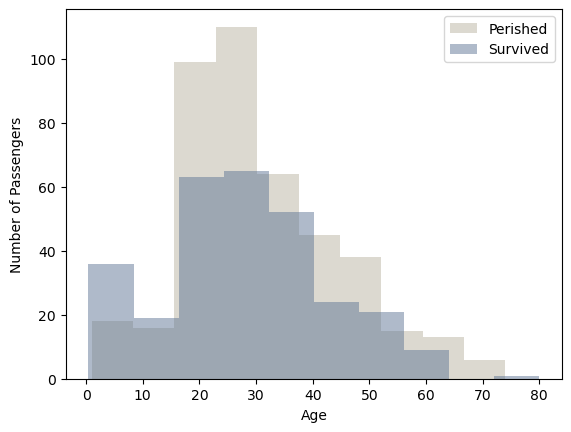

In [71]:
#looking at the survival rate by age
plt.hist(titanic[titanic['Survived'] == 0]['Age'], alpha=0.7, color='#cecabc', label='Perished')
plt.hist(titanic[titanic['Survived'] == 1]['Age'], alpha=0.5, color='#607696', label='Survived')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()




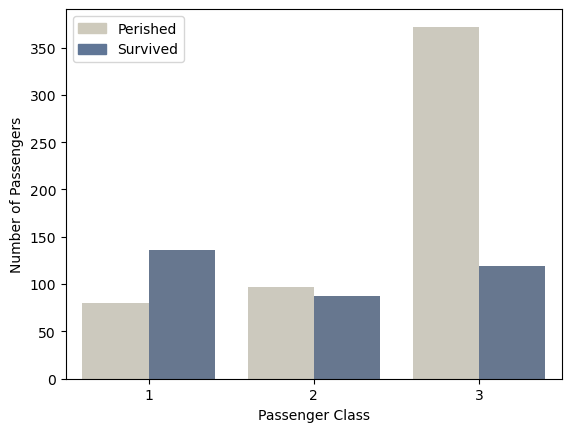

In [72]:
#create a histogram of the number of passengers who survived and did not survive by class         
sns.countplot(data=titanic, x='Pclass', hue='Survived', palette={0:'#cecabc', 1:'#607696'})
# Creating legend with color box 
died = mpatches.Patch(color='#cecabc', label='Perished') 
survived = mpatches.Patch(color='#607696', label='Survived') 
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.legend(handles=[died,survived]) 


plt.show()

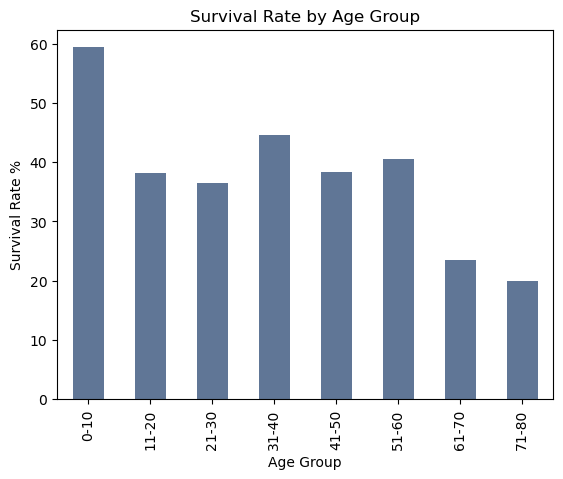

In [73]:
#looking at survival rate by age range
#dropped rows where age is missing from the titacic_train dataset
titanic = titanic.dropna(subset=['Age'])
titanic_age = titanic.copy()
age_bins = [ 0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
titanic_age['AgeGroup'] = pd.cut(titanic_age['Age'], age_bins, labels=age_labels)
age_grouped = titanic_age.groupby('AgeGroup')['Survived'].mean()*100
age_grouped.plot(kind='bar', color='#607696')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate %')
plt.title('Survival Rate by Age Group')
plt.show()


In [74]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1


In [75]:
#checking a simple correlation matrix    
corr_data= titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
corr_matrix = corr_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived      1.000000
Fare          0.268189
Parch         0.093317
SibSp        -0.017358
Embarked_Q   -0.049549
Age          -0.077221
Embarked_S   -0.164235
Pclass       -0.359653
Sex_male     -0.538826
Name: Survived, dtype: float64

In [76]:
#splitting the data into train and test
X = titanic.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)
y = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameters to test
parameters = {
    'n_neighbors' : range(1, 30),
    'weights': ['uniform', 'distance']
}

# Create grid search instance
grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'f1',
                           return_train_score = True)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



{'n_neighbors': 5, 'weights': 'uniform'}
0.6503496503496503
[[67 20]
 [30 26]]
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        87
           1       0.57      0.46      0.51        56

    accuracy                           0.65       143
   macro avg       0.63      0.62      0.62       143
weighted avg       0.64      0.65      0.64       143



In [77]:
# Create grid search instance
grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'recall',
                           return_train_score = True)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'n_neighbors': 6, 'weights': 'distance'}
0.6783216783216783
[[69 18]
 [28 28]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        87
           1       0.61      0.50      0.55        56

    accuracy                           0.68       143
   macro avg       0.66      0.65      0.65       143
weighted avg       0.67      0.68      0.67       143



In [78]:
# Create grid search instance
grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           return_train_score = True)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'n_neighbors': 13, 'weights': 'uniform'}
0.6713286713286714
[[72 15]
 [32 24]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        87
           1       0.62      0.43      0.51        56

    accuracy                           0.67       143
   macro avg       0.65      0.63      0.63       143
weighted avg       0.66      0.67      0.66       143



After reading some more about KNN, I was interested in seeing a plot of the n_neighbor values.  The KNN model is prone to overfitting, as a k value of 1 gives you an extremely high accuracy result for the training dataset.  I experimented with visualizing the effects of k below.

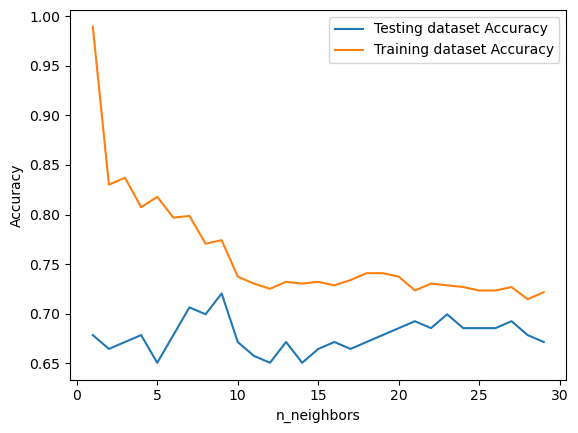

In [79]:
neighbors = np.arange(1, 30) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train, y_train) 
      
    # Compute training and test data accuracy 
    train_accuracy[i] = knn.score(X_train, y_train) 
    test_accuracy[i] = knn.score(X_test, y_test) 
  
# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 
